In [1]:
# Basics
import numpy as np
import pandas as pd
import os

# Scipy
from scipy import optimize
from scipy.ndimage import gaussian_filter
#from sklearn.neighbors import KDTree
from scipy import stats

# Gifs
from PIL import Image
import glob

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, AutoLocator, MaxNLocator
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib import colors
import matplotlib.ticker as ticker
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

# RC params
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams["axes.edgecolor"] = 'black'
rcParams["legend.edgecolor"] = '0.8'
plt.rcParams.update({'errorbar.capsize': 2})
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

def fmt(x, pos):
    ''' Used for the x10^ for colourbars'''
    if x == 0:
        return r'0'
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

## Change which model you want to run here!

Update the ```model_to_analyse``` variable

In [2]:
model_path = "/Users/maddie/Desktop/Thesis/Simulation_output/1_phase_revisions/run3"
os.chdir(model_path)

In [3]:
r      = 1 # kpc
to_pc  = 1000
t      = 0.47e8 #yr

# put values into physical quantities
def scale_arrays(array):

    if array.size == 0:
        return array # Make sure things can be multiplied

    array[:,0] = np.multiply(array[:,0], r * to_pc)  # all x
    array[:,1] = np.multiply(array[:,1], r * to_pc)  # all y
    array[:,2] = np.multiply(array[:,2], r * to_pc)  # all z

    return array


# Initialise arrays by setting them to []
def init_arr():
    return [], [], []

# Converting arrays to numpy
def convert_2_np(arr1, arr2, arr3):
    return np.asarray(arr1), np.asarray(arr2), np.asarray(arr3)



# Generate the time step to append to the 'mega array'
def gen_ts(arr1, arr2, arr3):
    ts = []
    
    # Make sure none of the arrays are empty
    if len(arr1) == 0:
        arr1 = [-10000, -10000, -10000.0, 2], [-10000.0, -10000.0, -10000.0, 2]
    if len(arr2) == 0:
        arr1 = [-10000, -10000, -10000.0, 3], [-10000.0, -10000.0, -10000.0, 3]
    if len(arr3) == 0:
        arr1 =[-10000, -10000, -10000.0, 4], [-10000.0, -10000.0, -10000.0, 4]
    

    arr1, arr2, arr3 = convert_2_np(arr1, arr2, arr3)

    # Apply scaling
    arr1 = scale_arrays(arr1)
    arr2 = scale_arrays(arr2)
    arr3 = scale_arrays(arr3) 
    
    # Append arrays
    ts.append(arr1)
    ts.append(arr2)
    ts.append(arr3)
    
    return ts





# read in the file into a 3D array
def tout_array_import():

    #an array for each time step
    timeStepArray = []

    gas, new, old = init_arr()
    
    data = []

    first_loop = True

    # The number of columns we want to import - all the rows!!!!
    # col_num = 12
    prev_row = -1
    particle_id = -1

    with open('anim.dat', 'r') as tout:

            for line in tout:

                row = np.fromstring(line, sep=' ')

                if row.size == 2: # New time step

                    if first_loop == True: # If it's the first loop
                        first_loop = False
                        timeStepArray.append(row[1]* t)
                        continue

                    # Store values
                    timeStepArray.append(row[1] * t)

                    print('appending timestep')
                    data.append(gen_ts(gas, new, old))

                    # Clear arrays
                    gas, new, old = init_arr()

                    # reset previous row
                    prev_row = -1

                    particle_id = -1



                elif row[3] == 2: 
                    gas.append(row)
                    particle_id += 1 # add 1 to the particle id
                    
                elif row[3] == 3: 
                    new.append(row)
                    particle_id += 1
                    
                elif row[3] == 4:
                    old.append(row)
                    particle_id += 1

                else:
                    print("WARNING: unknown iwas argument")
                    sys.exit()


    print('appending final timestep')

    data.append(gen_ts(gas, new, old)) # now a 4D array

        # Clear arrays
    gas, new, old = init_arr()
    return data, timeStepArray

In [4]:
data, timeStepArray = tout_array_import()

appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending timestep
appending ti

In [5]:
path = "gas_frame"
try:
    os.mkdir(path)
except OSError:
    print ("%s already exists" % path)
    #continue # dont try to re-evaluate things if you already find a file
else:
    print ("Successfully created the directory %s" % path)
    
os.chdir(path)

Successfully created the directory gas_frame


In [6]:
def make_dark_fig(data_x, data_y, bin_size, rang, i):
    hist1, xedges, yedges = np.histogram2d(data_x, data_y, bins = bin_size, range=([-rang,rang],[-rang,rang]))

    hist1 = gaussian_filter(hist1, sigma=smoothing_sigma) #because of per 100 pc bins
    fig, ax1 = plt.subplots()

    plt.style.use('dark_background')
    im2 = ax1.imshow(hist1.T/100, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap, vmin=0)
    ax1.plot([-1800,-800], [-1800, -1800], color='white')
    plt.axis('off')
    ax1.text(-1650, -1700, '1 kpc')
    ax1.text(-1900, 2200, 'Time =' + str(np.round(timeStepArray[i]/10**6, 1)) + ' Myr' )
    #plt.show()
    plt.savefig('dark_'+str(i), bbox_inches='tight', dpi = 300)
    plt.close()

In [7]:
rang = 2000
bin_size = 400
gamma = 0.4
smoothing_sigma = 1
cmap = plt.cm.get_cmap('magma')

In [11]:
# Test whether it looks pretty
i = 1
make_dark_fig(data[1][1][:,0], data[1][1][:,1], bin_size, rang, i) # Change to what you want

In [12]:
for i in range(len(data)):
    print('made ', i)
    make_dark_fig(data[i][0][:,0], data[i][0][:,1], bin_size, rang, i)

made  0
made  1
made  2
made  3
made  4
made  5
made  6
made  7
made  8
made  9
made  10
made  11
made  12
made  13
made  14
made  15
made  16
made  17
made  18
made  19
made  20
made  21
made  22
made  23
made  24
made  25
made  26
made  27
made  28
made  29
made  30
made  31
made  32
made  33
made  34
made  35
made  36
made  37
made  38
made  39
made  40
made  41
made  42
made  43
made  44
made  45
made  46
made  47
made  48
made  49
made  50
made  51
made  52
made  53
made  54
made  55
made  56
made  57
made  58
made  59
made  60
made  61
made  62
made  63
made  64
made  65
made  66
made  67
made  68
made  69
made  70
made  71
made  72
made  73
made  74
made  75
made  76
made  77
made  78
made  79
made  80
made  81
made  82
made  83
made  84
made  85
made  86
made  87
made  88
made  89
made  90
made  91
made  92
made  93
made  94
made  95
made  96
made  97
made  98
made  99
made  100


In [13]:
imgs = []
for i in range(len(data)):
    imgs.append('dark_'+str(i) + '.png')
    
    # Create the frames
frames = []

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('anim.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)
os.chdir('..')

In [14]:
path = "new_frame"
try:
    os.mkdir(path)
except OSError:
    print ("%s already exists" % path)
    #continue # dont try to re-evaluate things if you already find a file
else:
    print ("Successfully created the directory %s" % path)
    
os.chdir(path)

Successfully created the directory new_frame


In [15]:
for i in range(len(data)):
    try:
        print('made ', i)
        make_dark_fig(data[i][1][:,0], data[i][1][:,1], bin_size, rang, i)
    except:
        print('failed')

made  0
failed
made  1
made  2
made  3
made  4
made  5
made  6
made  7
made  8
made  9
made  10
made  11
made  12
made  13
made  14
made  15
made  16
made  17
made  18
made  19
made  20
made  21
made  22
made  23
made  24
made  25
made  26
made  27
made  28
made  29
made  30
made  31
made  32
made  33
made  34
made  35
made  36
made  37
made  38
made  39
made  40
made  41
made  42
made  43
made  44
made  45
made  46
made  47
made  48
made  49
made  50
made  51
made  52
made  53
made  54
made  55
made  56
made  57
made  58
made  59
made  60
made  61
made  62
made  63
made  64
made  65
made  66
made  67
made  68
made  69
made  70
made  71
made  72
made  73
made  74
made  75
made  76
made  77
made  78
made  79
made  80
made  81
made  82
made  83
made  84
made  85
made  86
made  87
made  88
made  89
made  90
made  91
made  92
made  93
made  94
made  95
made  96
made  97
made  98
made  99
made  100


In [16]:
imgs = []
for i in range(len(data)):
    imgs.append('dark_'+str(i) + '.png')
    
    # Create the frames
frames = []

for i in imgs:
    try:
        new_frame = Image.open(i)
        frames.append(new_frame)
    except:
        print("couldn't access frame ", i)
 
# Save into a GIF file that loops forever
frames[0].save('anim.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)
os.chdir('..')

couldn't access frame  dark_0.png


In [17]:
path = "old_frame"
try:
    os.mkdir(path)
except OSError:
    print ("%s already exists" % path)
    #continue # dont try to re-evaluate things if you already find a file
else:
    print ("Successfully created the directory %s" % path)
    
os.chdir(path)

Successfully created the directory old_frame


In [18]:
for i in range(len(data)):
    try:
        print('made ', i)
        make_dark_fig(data[i][2][:,0], data[i][2][:,1], bin_size, rang, i)
    except:
        print('failed')

made  0
made  1
made  2
made  3
made  4
made  5
made  6
made  7
made  8
made  9
made  10
made  11
made  12
made  13
made  14
made  15
made  16
made  17
made  18
made  19
made  20
made  21
made  22
made  23
made  24
made  25
made  26
made  27
made  28
made  29
made  30
made  31
made  32
made  33
made  34
made  35
made  36
made  37
made  38
made  39
made  40
made  41
made  42
made  43
made  44
made  45
made  46
made  47
made  48
made  49
made  50
made  51
made  52
made  53
made  54
made  55
made  56
made  57
made  58
made  59
made  60
made  61
made  62
made  63
made  64
made  65
made  66
made  67
made  68
made  69
made  70
made  71
made  72
made  73
made  74
made  75
made  76
made  77
made  78
made  79
made  80
made  81
made  82
made  83
made  84
made  85
made  86
made  87
made  88
made  89
made  90
made  91
made  92
made  93
made  94
made  95
made  96
made  97
made  98
made  99
made  100


In [19]:
imgs = []
for i in range(len(data)):
    imgs.append('dark_'+str(i) + '.png')
    
    # Create the frames
frames = []

for i in imgs:
    try:
        new_frame = Image.open(i)
        frames.append(new_frame)
    except:
        print("couldn't access frame ", i)
 
# Save into a GIF file that loops forever
frames[0].save('anim.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)
os.chdir('..')

In [20]:
path = "both_frame"
try:
    os.mkdir(path)
except OSError:
    print ("%s already exists" % path)
    #continue # dont try to re-evaluate things if you already find a file
else:
    print ("Successfully created the directory %s" % path)
    
os.chdir(path)

Successfully created the directory both_frame


In [21]:
def make_dark_fig_both(data_x_g, data_y_g, data_x_n, data_y_n, bin_size, rang, i, time, gcX, gcY):
    hist1, xedges, yedges = np.histogram2d(data_x_g, data_y_g, bins = bin_size, range=([-rang,rang],[-rang,rang]))
    hist2, xedges, yedges = np.histogram2d(data_x_n, data_y_n, bins = bin_size, range=([-rang,rang],[-rang,rang]))
    hist1 = gaussian_filter(hist1, sigma=smoothing_sigma) #because of per 100 pc bins
    hist2 = gaussian_filter(hist2, sigma=smoothing_sigma) #because of per 100 pc bins
    fig, (ax1,ax2) = plt.subplots(1,2)

    plt.style.use('dark_background')
    im1 = ax1.imshow(hist1.T/100, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap, vmin=0)
    
    im2 = ax2.imshow(hist2.T/100, norm=mcolors.PowerNorm(gamma), 
                 origin='lower', extent=[-rang, rang, -rang, rang], cmap=cmap, vmin=0)
    
    ax1.plot([-1800,-800], [-2500, -2500], color='white')
    ax2.plot([-1800,-800], [-2500, -2500], color='white')
    ax1.axis('off')
    ax2.axis('off')
    ax1.text(-1800, -2300, '1 kpc')
    ax2.text(-1800, -2300, '1 kpc')
    
    ax1.text(1300, 2200, 'Gas')
    ax2.text(1000, 2200, 'Stars')
    
    ax1.text(-1900, 3000, 'Time =' + str(np.round(time/10**6, 1)) + ' Myr' )
    
    ax1.scatter(gcX, gcY, s=70, facecolors='none', edgecolors='white')
    ax2.scatter(gcX, gcY, s=70, facecolors='none', edgecolors='white')
    
    #plt.show()
    plt.savefig('dark_'+str(i), bbox_inches='tight', dpi = 300)
    plt.close()

In [22]:
i = 1
make_dark_fig_both(data[i][0][:,0], data[i][0][:,1], data[i][1][:,0], data[i][1][:,1], bin_size, rang, i, timeStepArray[i], data[i][2][0,0], data[i][2][0,1])

In [23]:
for i in range(len(data)):
    try:
        print('made ', i)
        make_dark_fig_both(data[i][0][:,0], data[i][0][:,1], data[i][1][:,0], data[i][1][:,1], bin_size, rang, i, timeStepArray[i], data[i][2][0,0], data[i][2][0,1])
    except:
        print('failed')

made  0
failed
made  1
made  2
made  3
made  4
made  5
made  6
made  7
made  8
made  9
made  10
made  11
made  12
made  13
made  14
made  15
made  16
made  17
made  18
made  19
made  20
made  21
made  22
made  23
made  24
made  25
made  26
made  27
made  28
made  29
made  30
made  31
made  32
made  33
made  34
made  35
made  36
made  37
made  38
made  39
made  40
made  41
made  42
made  43
made  44
made  45
made  46
made  47
made  48
made  49
made  50
made  51
made  52
made  53
made  54
made  55
made  56
made  57
made  58
made  59
made  60
made  61
made  62
made  63
made  64
made  65
made  66
made  67
made  68
made  69
made  70
made  71
made  72
made  73
made  74
made  75
made  76
made  77
made  78
made  79
made  80
made  81
made  82
made  83
made  84
made  85
made  86
made  87
made  88
made  89
made  90
made  91
made  92
made  93
made  94
made  95
made  96
made  97
made  98
made  99
made  100


In [24]:
imgs = []
for i in range(len(data)):
    imgs.append('dark_'+str(i) + '.png')
    
    # Create the frames
frames = []

for i in imgs:
    try:
        new_frame = Image.open(i)
        frames.append(new_frame)
    except:
        print('could not make frame')
 
# Save into a GIF file that loops forever
frames[0].save('anim.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

os.chdir('..')

could not make frame


In [34]:
def scatter_zoom(data, i, time):
    plt.style.use('dark_background')
    fig, ax = plt.subplots()
    fig.set_size_inches(4,4)
    
    delta_x = data[i][2][0,0] - data[i-1][2][0,0]
    delta_y = data[i][2][0,1] - data[i-1][2][0,1]
    ax2 = plt.axes([0.9,0.2,0.3,0.3])
    ax2.set_xlim(-100, 100)
    ax2.set_ylim(-100, 100)
    ax2.arrow(0, 0, delta_x, delta_y, color = 'white', width = 10)
    
    ax.scatter(data[i][2][:,0] - data[i][2][0,0], data[i][2][:,1]- data[i][2][0,1], alpha = 0.2, s = 1, label = "1G")
    ax.scatter(data[i][0][:,0] - data[i][2][0,0], data[i][0][:,1]- data[i][2][0,1], alpha = 0.2, s = 1, label = "Gas")
    ax.scatter(data[i][1][:,0] - data[i][2][0,0], data[i][1][:,1]- data[i][2][0,1], alpha = 0.2, s = 1, label = "2G")

    ax.axis('off')
    ax.axis('equal')
    #ax.axis([-200, 200, -200, 200])
    leg = ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1), frameon = False, markerscale = 10)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax.text(-190, 230, 'Time =' + str(np.round(time/10**6, 1)) + ' Myr' )
    ax.text(-180, -165, '50 pc')
    ax.plot([-180, -130],[-180,-180], color = 'white')
    ax.set_xlim(-200, 200)
    ax.set_ylim(-200, 200)
    
    ax.text(220, -190, 'velocity\n vector')
    
    
    # Create a set of inset Axes: these should fill the bounding box allocated to
    # them.
   
    #ax2.quiver(0, 0, delta_x, delta_y, color = 'white',  linewidths = widths)
    ax2.axis('off')
    
    #plt.show()
    plt.savefig('dark_'+str(i), bbox_inches='tight', dpi = 300)
    plt.close()

In [35]:
i = 1
scatter_zoom(data, i, timeStepArray[i])

In [27]:
path = "scatter_frame_XZ"
try:
    os.mkdir(path)
except OSError:
    print ("%s already exists" % path)
    #continue # dont try to re-evaluate things if you already find a file
else:
    print ("Successfully created the directory %s" % path)
    
os.chdir(path)

Successfully created the directory scatter_frame_XZ


made  0
failed
made  1
made  2
made  3
made  4
made  5
made  6
made  7
made  8
made  9
made  10
made  11
made  12
made  13
made  14
made  15
made  16
made  17
made  18
made  19
made  20
made  21
made  22
made  23
made  24
made  25
made  26
made  27
made  28
made  29
made  30
made  31
made  32
made  33
made  34
made  35
made  36
made  37
made  38
made  39
made  40
made  41
made  42
made  43
made  44
made  45
made  46
made  47
made  48
made  49
made  50
made  51
made  52
made  53
made  54
made  55
made  56
made  57
made  58
made  59
made  60
made  61
made  62
made  63
made  64
made  65
made  66
made  67
made  68
made  69
made  70
made  71
made  72
made  73
made  74
made  75
made  76
made  77
made  78
made  79
made  80
made  81
made  82
made  83
made  84
made  85
made  86
made  87
made  88
made  89
made  90
made  91
made  92
made  93
made  94
made  95
made  96
made  97
made  98
made  99
made  100


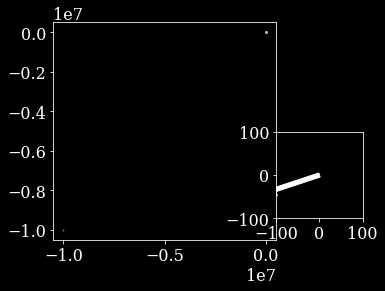

In [36]:
for i in range(len(data)):
    try:
        print('made ', i)
        scatter_zoom(data, i, timeStepArray[i])
    except:
        print('failed')

In [37]:
imgs = []
for i in range(len(data)):
    imgs.append('dark_'+str(i) + '.png')
    
    # Create the frames
frames = []

for i in imgs:
    try:
        new_frame = Image.open(i)
        frames.append(new_frame)
    except:
        print('could not make frame')
 
# Save into a GIF file that loops forever
frames[0].save('anim.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

os.chdir('..')

could not make frame
